# Integrate weather tool

In [27]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core

In [28]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [29]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [30]:
from typing import TypedDict
from IPython.display import Image, display
from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

@tool
def get_weather(loc):
    """Return the weather given a location"""
    if loc == "Jammu":
        return "It's sunny in Jammu"
    else:
        return "I don't know the weather in " + loc

@tool    
def get_forcast(loc):
    """Returns the forcast for a location"""
    if loc == "Jammu":
        return "It's going to be raining in Jammu"
    else:
        return "I don't know the forcast in " + loc
    

tools = [get_weather, get_forcast]
tool_node = ToolNode(tools=tools)

llm_with_tools = llm.bind_tools(tools)

In [31]:
# Invoke the llm directly
output = llm_with_tools.invoke("What's the the capital of India?")
print("output:", output)
print("tools_calls:", output.tool_calls)

output: content='The capital of India is New Delhi.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 74, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'stop', 'logprobs': None} id='run-0dc9bf6e-ad17-418e-9759-3a5dea00200b-0' usage_metadata={'input_tokens': 74, 'output_tokens': 10, 'total_tokens': 84, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
tools_calls: []


In [32]:
output = llm_with_tools.invoke("What's the weather in Jammu?")
print("output:", output)
print("tools_calls:", output.tool_calls)

# Comment
"""
When you invoke the llm with a tool, it only gives the tools_calls but do not execute the code automatically. 
To execute the code, you'd need to write the logic manually.
In langgraph flow this gets handled automatically. :)
You can also use `from langchain_core.runnables import RunnableWithTools` and AgentExecutor to run the tools automatically in langchain
"""


output: content='' additional_kwargs={'tool_calls': [{'id': 'call_55mzjWezuxw7YMk93zsmlSHJ', 'function': {'arguments': '{"loc":"Jammu"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 73, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-583cf32f-4e82-4b46-92ad-1dcfc33afa45-0' tool_calls=[{'name': 'get_weather', 'args': {'loc': 'Jammu'}, 'id': 'call_55mzjWezuxw7YMk93zsmlSHJ', 'type': 'tool_call'}] usage_metadata={'input_tokens': 73, 'output_tokens': 16, 'total_tokens': 89, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
tools_calls: 

In [33]:
if hasattr(output, "tool_calls"):
    tool_results = {}
    print("entered\n")
    
    for tool_call in output.tool_calls:
        print("Tool Call:\n", tool_call)
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        print("Tool Name:", tool_name, "Tool Args:", tool_args)
        if tool_name == "get_weather":
            print("tool_args:\n", tool_args)
            result = get_weather.invoke(input=tool_args) # Execute the tool
            tool_results[tool_name] = result

    print("Tool Results:", tool_results)
else:
    print("Output:", output)

entered

Tool Call:
 {'name': 'get_weather', 'args': {'loc': 'Jammu'}, 'id': 'call_55mzjWezuxw7YMk93zsmlSHJ', 'type': 'tool_call'}
Tool Name: get_weather Tool Args: {'loc': 'Jammu'}
tool_args:
 {'loc': 'Jammu'}
Tool Results: {'get_weather': "It's sunny in Jammu"}


## Using langgraph to invoke tools manually

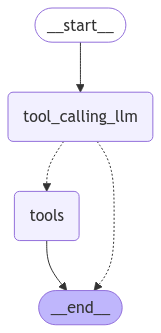

In [34]:
from typing import TypedDict
from IPython.display import Image, display
from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition


# Create a node which calls llm with access to tools
def tool_calling_llm(state):
    return {"messages": llm_with_tools.invoke(state["messages"])}


builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools=tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              # if latest message from the tool_calling_llm is a tool call, then call the tool_node
                              tools_condition)

builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [35]:
output = graph.invoke({"messages": "What is the forcast in Jammu?"})
print("output:", output)
print("messages", output["messages"])

output: {'messages': [HumanMessage(content='What is the forcast in Jammu?', additional_kwargs={}, response_metadata={}, id='294bb1db-b3aa-45b2-8dae-08d3d3780726'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NiMMTG6IdAsi9lPtf0gQNlT1', 'function': {'arguments': '{"loc":"Jammu"}', 'name': 'get_forcast'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 75, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4cbcc878-146a-49b4-ae7e-a88167ef0aec-0', tool_calls=[{'name': 'get_forcast', 'args': {'loc': 'Jammu'}, 'id': 'call_NiMMTG6IdAsi9lPtf0gQNlT1', 'type': 'tool_call'}], usage_metadata={'input_toke

In [36]:
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the forcast in Jammu?
================================== Ai Message ==================================
Tool Calls:
  get_forcast (call_NiMMTG6IdAsi9lPtf0gQNlT1)
 Call ID: call_NiMMTG6IdAsi9lPtf0gQNlT1
  Args:
    loc: Jammu
================================= Tool Message =================================
Name: get_forcast

It's going to be raining in Jammu
